In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
from evaluation.neuroprobe.config import ROOT_DIR, SAMPLING_RATE, BRAINTREEBANK_SUBJECT_TRIAL_MOVIE_NAME_MAPPING, NEUROPROBE_FULL_SUBJECT_TRIALS
from subject.braintreebank import BrainTreebankSubject
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import Ridge
from scipy.stats import pearsonr
from matplotlib.lines import Line2D
import torch
from sklearn.preprocessing import StandardScaler
from model.preprocessing.spectrogram import SpectrogramPreprocessor

SUBJECT_TRIAL_TO_MOVIE = {
    (subject_id, trial_id): BRAINTREEBANK_SUBJECT_TRIAL_MOVIE_NAME_MAPPING["btbank" + str(subject_id) + "_" + str(trial_id)] + ".mp4"
    for (subject_id, trial_id) in NEUROPROBE_FULL_SUBJECT_TRIALS
}

CLIP_DIR = "/om2/data/public/braintreebank_movies_clip_preprocessed_2/"
MOVIES_DIR = "/om2/data/public/braintreebank_movies/"
REGR_DIR = "/om2/data/public/braintreebank_movies_clip_preprocessed_2/regr_results_2/"

In [4]:
def obtain_neural_data_index(sub_id, trial_id, movie_times):
    # Data frames column IDs
    start_col, end_col = 'start', 'end'
    trig_time_col, trig_idx_col, est_idx_col, est_end_idx_col = 'movie_time', 'index', 'est_idx', 'est_end_idx'

    # Path to trigger times csv file
    trigger_times_file = os.path.join(ROOT_DIR, f'subject_timings/sub_{sub_id}_trial{trial_id:03}_timings.csv')

    trigs_df = pd.read_csv(trigger_times_file)
    # display(trigs_df.head())

    last_t = trigs_df[trig_time_col].iloc[-1]
    assert np.all(movie_times < last_t), "Movie times must be less than the last trigger time"
    
    # Vectorized nearest trigger finding
    start_indices = np.searchsorted(trigs_df[trig_time_col].values, movie_times)
    start_indices = np.maximum(start_indices, 0) # handle the edge case where movie starts right at the word
    
    # Vectorized sample index calculation
    return np.round(
        trigs_df.loc[start_indices, trig_idx_col].values + 
        (movie_times - trigs_df.loc[start_indices, trig_time_col].values) * SAMPLING_RATE
    ).astype(int)

def get_neural_data_at_index(subject_id, trial_id, electrode, start, end):
    subject = BrainTreebankSubject(subject_id, cache=False)
    neural_data = subject.get_electrode_data(electrode,trial_id,window_from=start, window_to=end)
    return neural_data

def get_movie_data(movie):
    clip_features_path = os.path.join(CLIP_DIR, movie.replace('.mp4', '_clip_features.npy'))
    timestamps_path = os.path.join(CLIP_DIR, movie.replace('.mp4', '_timestamps.npy'))
    movie_path = os.path.join(MOVIES_DIR, movie)

    clip_features = np.load(clip_features_path)  # shape: (num_samples, feature_dim)
    timestamps = np.load(timestamps_path)
    return clip_features, timestamps, movie_path

def get_subject_trial_from_movie(movie):
    subject_trial_list = []
    for subject_trial, movie_name in SUBJECT_TRIAL_TO_MOVIE.items():
        if movie_name == movie:
            subject_trial_list.append(subject_trial)
    return subject_trial_list

def process_subject_trial(subject_id, trial_id, timestamps, sampling_interval=1.0):
    subject = BrainTreebankSubject(subject_id, cache=False)

    trigger_times_file = os.path.join(ROOT_DIR, f'subject_timings/sub_{subject_id}_trial{trial_id:03}_timings.csv')
    trigs_df = pd.read_csv(trigger_times_file)
    last_trigger_time = trigs_df['movie_time'].iloc[-1]
    safe_end_timestamp = min(timestamps[-2], last_trigger_time - 1.0)  # 1 second buffer

    sampled_times = np.arange(0, safe_end_timestamp, sampling_interval)
    timestamp_indices = np.searchsorted(timestamps, sampled_times, side="left")
    return sampled_times, timestamp_indices, subject.get_electrode_labels(), subject

def get_base_data(subject_id, trial_id, electrode_label, sampled_times, subject, start_window_before_event=0.25, end_window_after_event=0.5):
    windowed_neural_data = []

    for t in sampled_times:
        window_start = t - start_window_before_event
        idx_start = obtain_neural_data_index(subject_id, trial_id, np.array([window_start])).item()
        idx_end = int(idx_start + (end_window_after_event+start_window_before_event) * 2048)

        data = subject.get_electrode_data(electrode_label, trial_id, window_from=idx_start, window_to=idx_end)
        windowed_neural_data.append(data.cpu().numpy() if hasattr(data, "cpu") else data)
    return windowed_neural_data

In [27]:
def run_regression(X, y_spectrogram, freq_bins, time_bins, subject_id, trial_id, electrode_label, alpha=0.1):
    n_timebins = y_spectrogram.shape[2]
    n_freqs = y_spectrogram.shape[3]

    n_samples = X.shape[0]
    n_folds = 3

    fold_size = n_samples // n_folds
    fold_indices = [i * fold_size for i in range(n_folds)] + [n_samples]

    # Store correlation and pval matrices for each fold
    fold_correlation_matrices = []
    fold_pval_matrices = []

    for fold in range(n_folds):
        fold_corr_matrix = np.zeros((n_freqs, n_timebins))
        fold_pval_matrix = np.zeros((n_freqs, n_timebins))
        # Chronological split: train on all but the current fold, test on the current fold
        test_start = fold_indices[fold]
        test_end = fold_indices[fold + 1]
        test_idx = np.arange(test_start, test_end)
        train_idx = np.concatenate([
            np.arange(0, test_start),
            np.arange(test_end, n_samples)
        ]) if n_folds > 1 else np.arange(0, test_start)  # For n_folds=1, just use all before test

        X_train, X_test = X[train_idx], X[test_idx]

        # Normalize features using StandardScaler (fit on train, transform both train and test)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        for t in tqdm(range(n_timebins), desc=f"Timebin (Fold {fold+1}/{n_folds})", leave=False):
            for f in range(n_freqs):
                y_vals = y_spectrogram[:, 0, t, f].cpu().numpy() if hasattr(y_spectrogram, 'cpu') else y_spectrogram[:, 0, t, f]
                y_train, y_test = y_vals[train_idx], y_vals[test_idx]
                if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
                    # Not enough variance to compute correlation
                    fold_corr_matrix[f, t] = np.nan
                    fold_pval_matrix[f, t] = np.nan
                    continue
                reg = Ridge(alpha=alpha)
                reg.fit(X_train_scaled, y_train)
                y_pred_test = reg.predict(X_test_scaled)
                corr, pval = pearsonr(y_test, y_pred_test)
                fold_corr_matrix[f, t] = corr
                fold_pval_matrix[f, t] = pval

        fold_correlation_matrices.append(fold_corr_matrix)
        fold_pval_matrices.append(fold_pval_matrix)

    # Find the fold with the highest sum of absolute correlation values
    fold_sums = [np.nansum(np.abs(mat)) for mat in fold_correlation_matrices]
    best_fold_idx = np.argmax(fold_sums)

    test_correlation_matrix = fold_correlation_matrices[best_fold_idx]
    test_pval_matrix = fold_pval_matrices[best_fold_idx]

    return test_correlation_matrix, test_pval_matrix

    # save_dir = os.path.join(REGR_DIR, f"btbank{subject_id}", f"trial_{trial_id}")
    # os.makedirs(save_dir, exist_ok=True)
    # save_path = os.path.join(save_dir, f"{electrode_label}_test_correlation.pdf")
    # plt.savefig(save_path, dpi=200)
    # plt.close()

    # np.save(os.path.join(save_dir, f"{electrode_label}_test_correlation.npy"), test_correlation_matrix)
    # np.save(os.path.join(save_dir, f"{electrode_label}_test_pval.npy"), test_pval_matrix)

In [28]:
def graph_regression(test_correlation_matrix, test_pval_matrix, subject_id, trial_id, electrode_label, alpha, freq_bins, time_bins):
    event_time = 0.25

    plt.figure(figsize=(10, 5))
    im = plt.imshow(
        test_correlation_matrix,
        aspect='auto',
        origin='lower',
        cmap='viridis',
        extent=[time_bins[0]-event_time,time_bins[-1]-event_time,freq_bins[0],freq_bins[-1]]
    )

    star_y, star_x = np.where(test_pval_matrix < 0.05)

    time_edges = np.linspace(
        time_bins[0]-event_time,
        time_bins[-1]-event_time,
        test_correlation_matrix.shape[1] + 1
    )
    freq_edges = np.linspace(
        freq_bins[0],
        freq_bins[-1],
        test_correlation_matrix.shape[0] + 1
    )
    time_centers = (time_edges[:-1] + time_edges[1:]) / 2
    freq_centers = (freq_edges[:-1] + freq_edges[1:]) / 2 - 0.3

    for y, x in zip(star_y, star_x):
        plt.text(
            time_centers[x], freq_centers[y], '*',
            color='white', fontsize=14, ha='center', va='center', fontweight='bold'
        )
    event_line = plt.axvline(0.0, color='white', linestyle='--', linewidth=1.5, label='Event (t=0)')
    asterisk_handle = Line2D([0], [0], marker='*', color='w', linestyle='None', markersize=14, markerfacecolor='w', label='p < 0.05')

    plt.colorbar(im, label='Test Correlation')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'btbank{subject_id}_{trial_id}_{electrode_label} (alpha={alpha})\nRidge Regression: CLIP -> Neural Data')
    plt.legend(handles=[event_line, asterisk_handle], loc='upper left', frameon=True)
    plt.tight_layout()

    plt.show()

In [6]:
def process_movie(movie):
    clip_features, timestamps, movie_path = get_movie_data(movie)
    subject_trial_list = get_subject_trial_from_movie(movie)

    for subject_trial in tqdm(subject_trial_list, desc='Processing subject trials'):
        subject_id, trial_id = subject_trial
        sampled_times, timestamp_indices, unique_electrodes, subject = process_subject_trial(subject_id, trial_id, timestamps)

        for electrode_label in unique_electrodes:
            windowed_neural_data = get_base_data(subject_id, trial_id, electrode_label, sampled_times, subject)
            y = np.stack(windowed_neural_data)
            X = clip_features[timestamp_indices]

            y_copy = y.copy()
            y_tensor = torch.tensor(y_copy)
            y_tensor = y_tensor.reshape(y_copy.shape[0], 1, y_copy.shape[1])

            spec_preproc = SpectrogramPreprocessor()
            y_spectrogram, freq_bins, time_bins = spec_preproc({'data': y_tensor, 'metadata': {'sampling_rate': 2048}})  # shape: (batch_size, n_electrodes, n_timebins, n_freqs)

            run_regression(X, y_spectrogram, freq_bins, time_bins, subject_id, trial_id, electrode_label)


# movies_list = [f for f in os.listdir(MOVIES_DIR) if os.path.isfile(os.path.join(MOVIES_DIR, f))]
# for movie in tqdm(movies_list, desc='Processing movies'):
#     process_movie(movie)

In [9]:
movie = 'ant-man.mp4'

clip_features, timestamps, movie_path = get_movie_data(movie)
subject_trial_list = get_subject_trial_from_movie(movie)

for subject_trial in tqdm(subject_trial_list, desc='Processing subject trials'):
    subject_id, trial_id = subject_trial
    sampled_times, timestamp_indices, unique_electrodes, subject = process_subject_trial(subject_id, trial_id, timestamps)


    electrodes = ['P2e8']

    for electrode_label in electrodes:
        windowed_neural_data = get_base_data(subject_id, trial_id, electrode_label, sampled_times, subject)
        y = np.stack(windowed_neural_data)
        X = clip_features[timestamp_indices]

        print('got base data')

        y_copy = y.copy()
        y_tensor = torch.tensor(y_copy)
        y_tensor = y_tensor.reshape(y_copy.shape[0], 1, y_copy.shape[1])

        spec_preproc = SpectrogramPreprocessor()
        y_spectrogram, freq_bins, time_bins = spec_preproc({'data': y_tensor, 'metadata': {'sampling_rate': 2048}})  # shape: (batch_size, n_electrodes, n_timebins, n_freqs)

        print('got spectrogram')

        run_regression(X, y_spectrogram, freq_bins, time_bins, subject_id, trial_id, electrode_label)

        print('ran regression')

Processing subject trials:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s]

Processing subject trials:   0%|                                                                                                                       | 0/1 [06:08<?, ?it/s]

got base data


TypeError: get_default_config() missing 2 required positional arguments: 'random_string' and 'wandb_project'

got spectrogram


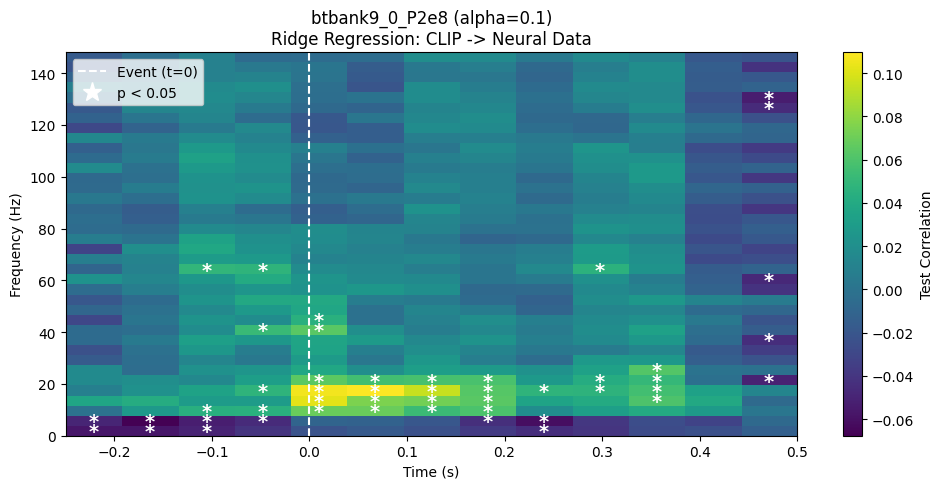

ran regression


In [29]:
import importlib
import model.preprocessing.spectrogram
importlib.reload(model.preprocessing.spectrogram)
from model.preprocessing.spectrogram import SpectrogramPreprocessor

spec_preproc = SpectrogramPreprocessor()
y_spectrogram, freq_bins, time_bins = spec_preproc({'data': y_tensor, 'metadata': {'sampling_rate': 2048}})  # shape: (batch_size, n_electrodes, n_timebins, n_freqs)

print('got spectrogram')

alpha = 0.1
test_correlation_matrix, test_pval_matrix = run_regression(X, y_spectrogram, freq_bins, time_bins, subject_id, trial_id, electrode_label, alpha)
graph_regression(test_correlation_matrix, test_pval_matrix, subject_id, trial_id, electrode_label, alpha, freq_bins, time_bins)


print('ran regression')

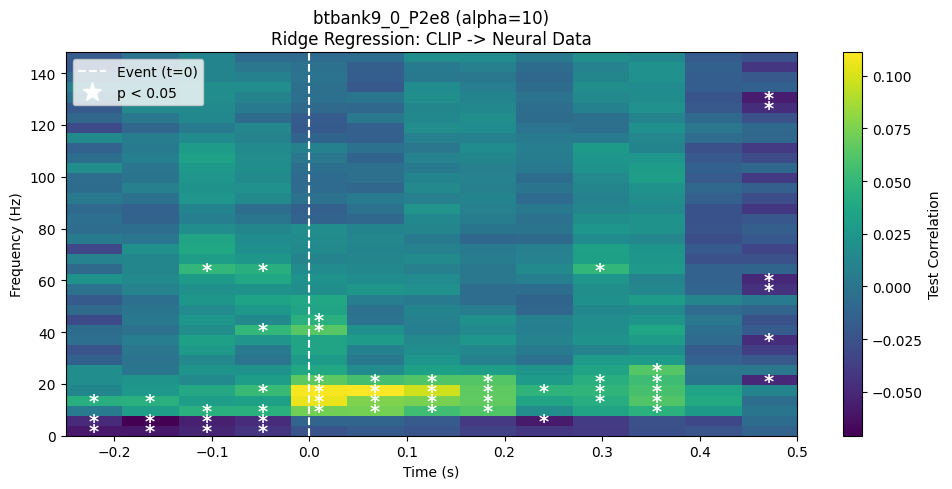

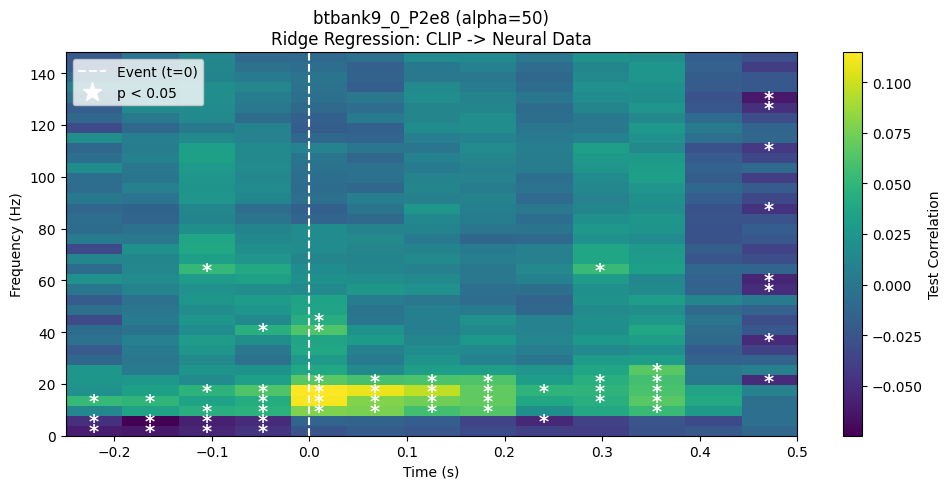

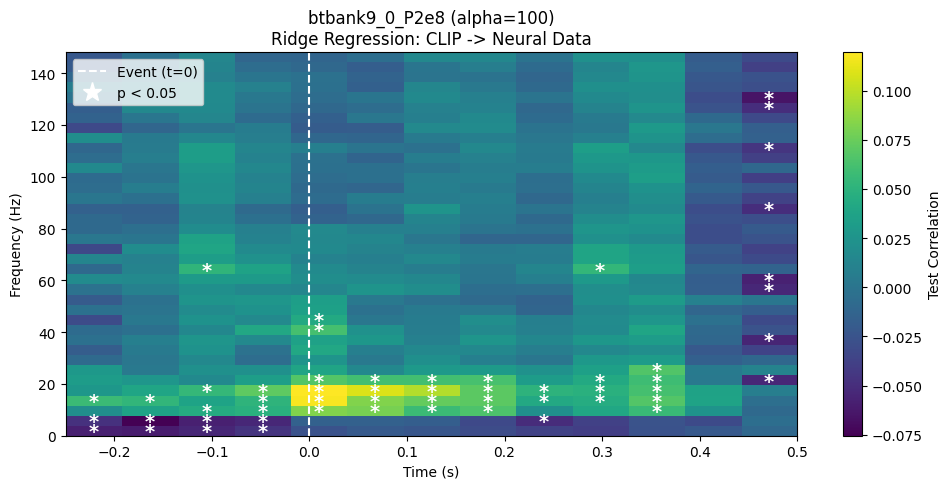

In [24]:
for alpha in [10, 50, 100]:
    run_regression(X, y_spectrogram, freq_bins, time_bins, subject_id, trial_id, electrode_label, alpha)